## REFERÊNCIAS

IDEIA ORIGINAL: <br/>
Adam Rosembrock <br/>
pyimagesearch.com - 
https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/




## ATENÇÃO

Os métodos e técnicas usados neste vídeo são apenas para fins educacionais. Esse não é um estudo cientificamente rigoroso, nem será publicado em uma revista científica´.

## AGENDA

Dentro do tutorial de hoje, você aprenderá como:

- Abrir uma base de imagens de raio-X  (open data) de pacientes com resultado POSITIVO para COVID-19 e imagens de pacientes com resultado NEGATIVO.


- Dividir o dataset de imagens em conjunto de teste e conjunto de treino 


- Aplicar a técnica de aumento de dados (Data Augmentation)



- Aplicar a técnica de transferência de inteligência entre redes neurais (Transfer Learning)


- Treinar uma Rede Neural Convolucional com o Tensorflow/Keras para detectar automaticamente o COVID-19 em imagens de raios-X 


- Avaliar os resultados sob uma perspectiva educacional

## importações de bibliotecas

In [26]:
from PIL import Image
from os import listdir
from os.path import isdir
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

### Carregando uma imagem

In [27]:
def select_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    image = image.resize((150,150))
    # convert to array
    return np.asarray(image)

### Carregando uma classe

In [28]:
def load_classes(diretorio, classe, imagens, labels):
    # iterando arquivos

    for filename in listdir(diretorio):

        path = diretorio + filename

        try:
            imagens.append(select_image(path))
            labels.append(classe)
        except:
            print("Erro ao ler imagem {}".format(path))

    return imagens, labels

### Selecionando Dataset

In [29]:
def select_data_set(diretorio):

    imagens = list()
    labels = list()

    for subdir in listdir(diretorio):
        # path
        path = diretorio + subdir + '\\'

        if not isdir(path):
            continue
        imagens, labels = load_classes(path, subdir, imagens, labels)

    return imagens, labels

### Carregando dataset Covid-19

In [30]:
covid_dataset = "D:\\dataset\\covid-sandeco\\images\\"
imagens, labels  = select_data_set(covid_dataset)
imagens = np.array(imagens) / 255.0  ## convertendo de lista para array
labels = np.array(labels)  ## convertendo de lista para array

### Tratando classes - Labels

In [31]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Definindo hyperparametros

In [32]:
batch_size   = 32
input_shape  = (150, 150, 3)
random_state = 42
alpha        = 1e-5
epoch        = 100

## CALLBACKS

Callback são classes que auxiliam o treinamento do modelo usando o Keras. As classes que usaremos são:

- ModelCheckpoint
- ReduceLROnPlateau
- EarlyStopping

In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#### ModelCheckpoint

ModelCheckpoint nos ajudará a salvar o modelo para cada época, para que possamos treinar nosso modelo e não nos preocuparmos com possíveis problemas que possam acontecer, como travamento da máquina.

- **filepath**: onde será salvo o modelo
- **monitor**: métrica a ser monitorada
- **verbose**: (1) mostra na barra de progresso (0) não
- **save_best_only**: Salvar somente o melhor modelo
- **mode**: como vamos monitorar o 'val_acc' o valor aqui vai ser 'max'. Queremos a máxima acurácia.


In [34]:
filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#### ReduceLROnPlateau

Nos auxiliara a reduzir a taxa de aprendizado pelo fator (factor) caso não ocorra a mudança no loss.

- **monitor**: métrica a ser monitorada
- **factor**: fator de redução caso estejamos em um plator
- **min_delta**: valor mínimo da perda
- **patience**: só altere pelo fator após se repitir por 'patience' vezes.
- **verbose**: (1) mostra na barra de progresso (0) não


In [35]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)

### Array de Callbacks

In [36]:
callbacks = [checkpoint, lr_reduce]

### Particionando dataset em teste e treino

In [37]:
(trainX, testX, trainY, testY) = train_test_split(imagens, labels, test_size=0.20, stratify=labels, random_state=random_state)

## DATA AUGMENTATION

In [38]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2)

train_datagen.fit(trainX)

data_aug = train_datagen.flow(trainX, trainY, batch_size=batch_size)

## TRANSFER LEARNING

In [39]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

In [40]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Retreinando parte da VGG19


explicar aqui

In [41]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [42]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## CRIANDO O MODELO COM A VGG19 COMO BASE

In [43]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(2, activation='softmax'))

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

## COMPILANDO O MODELO

In [45]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

## TREINANDO O MODELO

***Obs: não treinar na hora da live***

In [46]:
history = model.fit_generator(
                              data_aug,
                              steps_per_epoch=len(trainX)// batch_size, # parte inteira da divisão
                              validation_data=(testX, testY),
                              validation_steps=len(testX) // batch_size,# parte inteira da divisão
                              callbacks=callbacks,
                              epochs=epoch)



Epoch 1/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 13ms/sample - loss: 1.6575 - acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to transferlearning_weights.hdf5
3/3 [==============================] - 3s 841ms/step - loss: 0.6585 - acc: 0.5286 - val_loss: 1.3463 - val_acc: 0.5000
Epoch 2/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 1.5400 - acc: 0.8077

Epoch 00002: val_acc improved from 0.50000 to 0.80769, saving model to transferlearning_weights.hdf5
3/3 [========================


Epoch 00014: val_acc did not improve from 0.98077
3/3 [==============================] - 1s 184ms/step - loss: 0.0417 - acc: 0.9929 - val_loss: 3.2279 - val_acc: 0.5769
Epoch 15/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 5ms/sample - loss: 2.7261 - acc: 0.5962

Epoch 00015: val_acc did not improve from 0.98077
3/3 [==============================] - 1s 206ms/step - loss: 0.0669 - acc: 0.9792 - val_loss: 2.7261 - val_acc: 0.5962
Epoch 16/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 2.6181 - acc: 0.5962

Epoch 0


Epoch 00028: val_acc did not improve from 0.98077

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
3/3 [==============================] - 1s 178ms/step - loss: 0.0403 - acc: 1.0000 - val_loss: 1.1277 - val_acc: 0.7885
Epoch 29/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 0.6690 - acc: 0.8077

Epoch 00029: val_acc did not improve from 0.98077
3/3 [==============================] - 1s 188ms/step - loss: 0.0635 - acc: 0.9688 - val_loss: 0.6690 - val_acc: 0.8077
Epoch 30/100
26/3 [==========================================================================================================================================================================================================================================


Epoch 00042: val_acc did not improve from 0.98077
3/3 [==============================] - 1s 203ms/step - loss: 0.0330 - acc: 0.9948 - val_loss: 0.2518 - val_acc: 0.8846
Epoch 43/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 0.2272 - acc: 0.9038

Epoch 00043: val_acc did not improve from 0.98077

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
3/3 [==============================] - 0s 163ms/step - loss: 0.1361 - acc: 0.9857 - val_loss: 0.2272 - val_acc: 0.9038
Epoch 44/100
26/3 [==========================================================================================================================================================================================================================================


Epoch 00056: val_acc did not improve from 0.98077
3/3 [==============================] - 1s 188ms/step - loss: 0.0517 - acc: 0.9844 - val_loss: 0.1228 - val_acc: 0.9615
Epoch 57/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 0.1197 - acc: 0.9615

Epoch 00057: val_acc did not improve from 0.98077
3/3 [==============================] - 0s 159ms/step - loss: 0.0807 - acc: 0.9643 - val_loss: 0.1197 - val_acc: 0.9615
Epoch 58/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 0.1176 - acc: 0.9615

Epoch 0


Epoch 00070: val_acc did not improve from 0.98077
3/3 [==============================] - 1s 188ms/step - loss: 0.0860 - acc: 0.9844 - val_loss: 0.0947 - val_acc: 0.9615
Epoch 71/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 0.0939 - acc: 0.9615

Epoch 00071: val_acc did not improve from 0.98077
3/3 [==============================] - 0s 160ms/step - loss: 0.1038 - acc: 0.9643 - val_loss: 0.0939 - val_acc: 0.9615
Epoch 72/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 0.0923 - acc: 0.9615

Epoch 0


Epoch 00084: val_acc did not improve from 0.98077
3/3 [==============================] - 0s 162ms/step - loss: 0.0856 - acc: 0.9786 - val_loss: 0.0797 - val_acc: 0.9615
Epoch 85/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 0.0790 - acc: 0.9615

Epoch 00085: val_acc did not improve from 0.98077
3/3 [==============================] - 1s 191ms/step - loss: 0.0412 - acc: 0.9896 - val_loss: 0.0790 - val_acc: 0.9615
Epoch 86/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 4ms/sample - loss: 0.0781 - acc: 0.9615

Epoch 0


Epoch 00098: val_acc did not improve from 0.98077

Epoch 00098: ReduceLROnPlateau reducing learning rate to 1.0000000692397185e-22.
3/3 [==============================] - 1s 212ms/step - loss: 0.0629 - acc: 0.9844 - val_loss: 0.0738 - val_acc: 0.9615
Epoch 99/100
26/3 [====================================================================================================================================================================================================================================================================] - 0s 5ms/sample - loss: 0.0730 - acc: 0.9615

Epoch 00099: val_acc did not improve from 0.98077
3/3 [==============================] - 1s 215ms/step - loss: 0.0846 - acc: 0.9857 - val_loss: 0.0730 - val_acc: 0.9615
Epoch 100/100
26/3 [========================================================================================================================================================================================================================================

# ANALISANDO DADOS

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

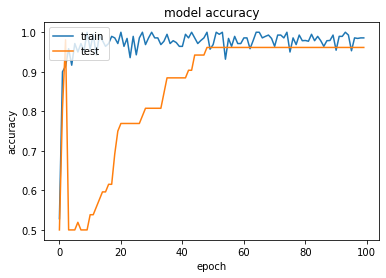

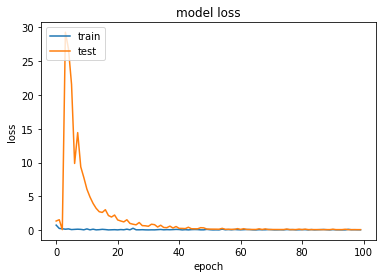

In [48]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Gerando matriz de confusão

In [49]:
from sklearn.metrics import confusion_matrix
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testY,axis = 1)

Acurácia: 0.9615
Sensitividade: 1.0000
Especificidade: 0.9231


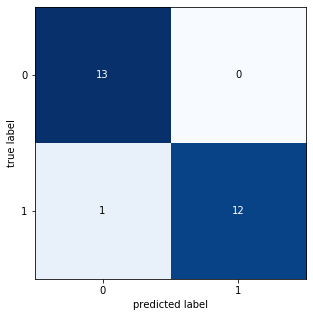

In [50]:
cm = confusion_matrix(y_true, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

### **Detector COVID-19 automático 96,15% de Acurácia.**

Também estamos obtendo 100% de sensibilidade e 92% de especificidade, o que implica que:

- Sensibilidade, capacidade indentificar caso positivo de COVID-19 com o modelo é de 100%.


- Especificidade, capacidade indentificar caso Não-Positivo de COVID-19 com o modelo é de 92,31%.


- Como mostra nosso gráfico de histórico de treinamento, nossa rede não está adaptando demais, apesar de ter dados de treinamento limitado